# 1. Load Library

In this section we import all the necessary libraries.

In [1]:
!pip install kagglehub

  Obtaining dependency information for kagglehub from https://files.pythonhosted.org/packages/87/4b/b5023905576b960483207ab6506694101c594c18577e5a36a7189823015e/kagglehub-0.3.11-py3-none-any.whl.metadata
  Using cached kagglehub-0.3.11-py3-none-any.whl.metadata (32 kB)
Using cached kagglehub-0.3.11-py3-none-any.whl (63 kB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os

print('Libraries loaded successfully')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Libraries loaded successfully


/opt/anaconda3/envs/UCL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Dataset

Load the dataset (e.g., a CSV file) and preview it.

In [5]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

    files = os.listdir(path)
    csv_path = os.path.join(path, 'GDSC_DATASET.csv')
    df = pd.read_csv(csv_path)
    df.head()

print("Path to dataset files:", path)

Path to dataset files: /Users/shijie/.cache/kagglehub/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc/versions/2


In [6]:
df.head()

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


# 3. Define Base Learner

Define the base learner that will be used in the different learning methods. For example, a simple Logistic Regression classifier.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define the base learner as random forest
base_learner = RandomForestRegressor()

print('Base learner defined:')
print(base_learner)

Base learner defined:
RandomForestRegressor()


# 4. Offline Learning Method

Implement the offline (batch) learning method where the base learner is trained on the entire dataset.

In [25]:
tmp = df.copy()
# Filter for adherent cells
# Note: The original code had a syntax error in the filter condition
# Corrected to use the correct syntax for filtering
# tmp = tmp[tmp['Growth Properties'] == 'Adherent']
tmp = tmp[tmp['DRUG_ID'] == 1003]
tmp

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,1660034,SNU-407,COREAD,1003,Camptothecin,-1.612538,0.898987,0.352188,large_intestine,large_intestine,COAD/READ,MSI-H,R,Adherent,Y,Y,Y,TOP1,DNA replication
963,1660035,SNU-61,COREAD,1003,Camptothecin,1.343563,0.984610,1.961691,large_intestine,large_intestine,COAD/READ,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
964,1660036,SNU-81,COREAD,1003,Camptothecin,0.073547,0.984230,1.270207,large_intestine,large_intestine,COAD/READ,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
965,1674021,SNU-C5,COREAD,1003,Camptothecin,-2.421554,0.835886,-0.088296,large_intestine,large_intestine,COAD/READ,MSI-H,R,Adherent,Y,Y,Y,TOP1,DNA replication


MSE of the model: 2.57
r2 of the model: 0.28


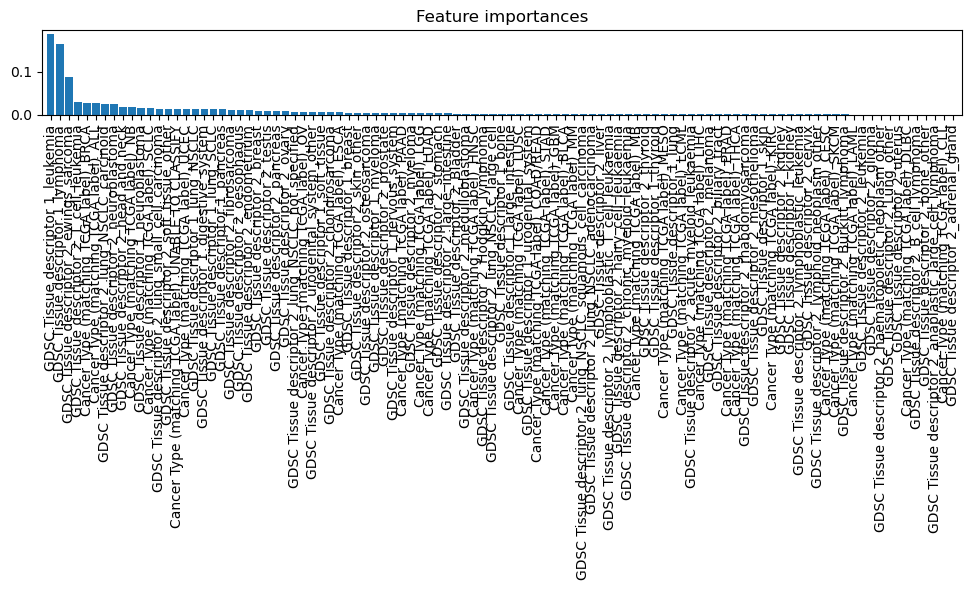

In [34]:
from sklearn.metrics import mean_squared_error, r2_score

categorical_features = ['GDSC Tissue descriptor 1',
                        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
                        'TARGET', 'TARGET_PATHWAY']
tmp = df.copy()
tmp = tmp[tmp['DRUG_ID'] == 1003]
X = tmp[categorical_features]
y = tmp['LN_IC50']

# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train the base learner
base_learner.fit(X_train, y_train)

# evaluate the model
y_pred = base_learner.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE of the model: {mse:.2f}')
print(f'r2 of the model: {r2:.2f}')

# visualize the feature importance
importances = base_learner.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# 5. Passive Learning Method

Implement the passive learning method. This method randomly select instances from sample space for model training.

In [45]:
from sklearn.metrics import mean_squared_error, r2_score
import random

mse_passive = []
r2_passive = []

categorical_features = ['GDSC Tissue descriptor 1',
                        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
                        'TARGET', 'TARGET_PATHWAY']
tmp = df.copy()
tmp = tmp[tmp['DRUG_ID'] == 1003]
X = tmp[categorical_features]
y = tmp['LN_IC50']

# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

for seed in range(5):
    data = X.copy()
    labels = y.copy()

    # Split the data into training, validation, and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
    X_pool, X_val, Y_pool, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=seed)
    x_train, _, y_train, _ = train_test_split(X_pool, Y_pool, train_size=0.05, random_state=seed)
    overall_length = X_pool.shape[0]

    overall_mse = []
    overall_r2 = []
    predict_mean = []
    # add the most uncertain sample to the training set
    while x_train.shape[0] < overall_length:
        # Train the model
        model = base_learner.fit(x_train, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        # Calculate the mean squared error and R^2 score
        overall_mse.append(mean_squared_error(Y_test, y_pred))
        overall_r2.append(r2_score(Y_test, y_pred))
        
        # randomly select a sample from the training set
        random_index = random.randint(0, X_pool.shape[0]-1)
        X_new = X_pool.iloc[[random_index]]
        y_new = Y_pool.iloc[[random_index]]

        # add the selected sample to the training set
        x_train = pd.concat([x_train, X_new], ignore_index=True)
        y_train = pd.concat([y_train, y_new], ignore_index=True)

        # remove the selected sample from the training set
        X_pool = X_pool.drop(X_pool.index[random_index])
        Y_pool = Y_pool.drop(Y_pool.index[random_index])

    mse_passive.append(overall_mse)
    r2_passive.append(overall_r2)
    print(f"Seed {seed} done")

Seed 1 done
Seed 2 done
Seed 3 done
Seed 4 done
Seed 5 done
Seed 6 done
Seed 7 done
Seed 8 done
Seed 9 done
Seed 10 done


Mean MSE of the model: 2.64
Mean r2 of the model: 0.20


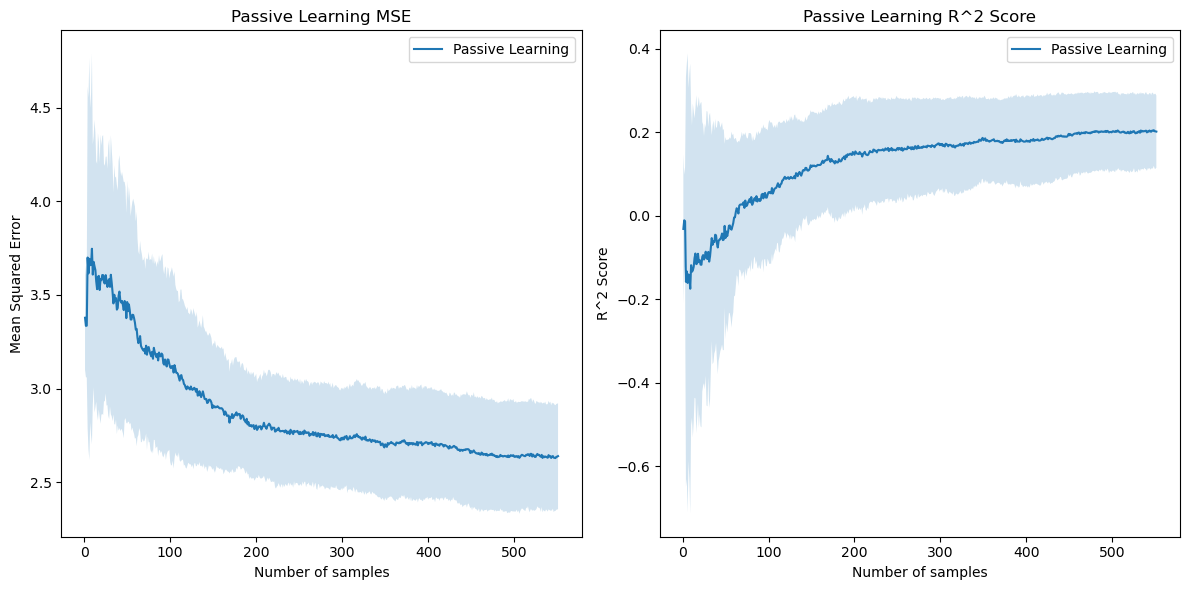

In [47]:
# Calculate the mean and standard deviation of MSE and R^2 scores
mse_passive = np.array(mse_passive)
mean_mse_passive = np.mean(mse_passive, axis=0)
std_mse_passive = np.std(mse_passive, axis=0)
r2_passive = np.array(r2_passive)
mean_r2_passive = np.mean(r2_passive, axis=0)
std_r2_passive = np.std(r2_passive, axis=0)
print(f'Mean MSE of the model: {mean_mse_passive[-1]:.2f}')
print(f'Mean r2 of the model: {mean_r2_passive[-1]:.2f}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mean_mse_passive) + 1), mean_mse_passive, label='Passive Learning')
plt.fill_between(range(1, len(mean_mse_passive) + 1), mean_mse_passive - std_mse_passive,
                 mean_mse_passive + std_mse_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('Mean Squared Error')
plt.title('Passive Learning MSE')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(mean_r2_passive) + 1), mean_r2_passive, label='Passive Learning')
plt.fill_between(range(1, len(mean_r2_passive) + 1), mean_r2_passive - std_r2_passive,
                 mean_r2_passive + std_r2_passive, alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('R^2 Score')
plt.title('Passive Learning R^2 Score')
plt.legend()
plt.tight_layout()
plt.show()



# 6. Active Learning Method

### 6.1 Uncertainty based method


In [ ]:
# Placeholder for active learning implementation

# Example: Select samples for which the model is most uncertain
print('Active learning method executed.')

### 6.2 Query by committee

In [ ]:
def query_by_committee(committee, X_pool):

    predictions = []
    for i, tree in enumerate(committee.estimators_):
        pred = tree.predict(X_pool)
        predictions.append(pred)

    predictions = np.array(predictions)

    disagreements = []
    n_models = len(committee.estimators_)
    for i in range(X_pool.shape[0]):
        # predict using different models
        sample_preds = predictions[:, i].astype(int)
        # number of votes for each class
        counts = np.bincount(sample_preds)  
        # vote ratio
        vote_ratio = counts / n_models 
        # disagraament
        disagree = entropy(vote_ratio, base=2)
        disagreements.append(disagree)
    
    return np.array(disagreements)